In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import pandas as pd
import Quandl
from lxml import etree
import requests

%matplotlib inline

# Covered interest parity

Covered interest parity is a no-arbitrage condition in foreign exchange markets. In terms of US dollars and British pounds, the covered interest parity condition can be expressed as:
    $$
    1+i_{\unicode{x24}}  = (1+i_{\unicode{xA3}}) \cdot \frac{F_{\unicode{x24}/\unicode{xA3}}}{E_{\unicode{x24}/\unicode{xA3}}}
    $$
Where $i_{\unicode{x24}}$ is the risk-free interest rate on dollars, $i_{\unicode{xA3}}$ is the risk-free intrest rate on pounds, 
$E_{\unicode{x24}/\unicode{xA3}}$ is the current spot rate in terms of dollars per pound, and $F_{\unicode{x24}/\unicode{xA3}}$ is the forward exchagne rate. The left-side of the equation is the risk-free return on dollars and the right-side is the risk-free return on pounds expressed in dollars. Equilibrium requires equality between the two returns because otherwise a person could earn risk-free profit by borrowing on one currency and saving in another.

Historical data on forward exchange rates is not readily available for many countries. This program uses data from [Quandl](https://www.quandl.com/) and from the [Federal Reserve Bank of New York](https://www.newyorkfed.org/) to obtain interest, spot exchange, and forward exchange rate data for the purposes of evaluating the covered interest parity condition.  All intrest rates used below are 6-month Libor rates and all forward rates are for transactions to be executed in 6-months and all exchange rates are expressed in terms of US dollars per unit of foreign currency.

* Yen (daily)
* Euro (daily)
* Pound (monthly)
* Swiss franc (monthly)

Note: since the interest rates are expressed in annualized terms, the interest rate terms in the covered interest parity condition must be divided by 2:
    $$
    1+\frac{i_{\unicode{x24}}}{2}  = \left(1+\frac{i_{\unicode{xA3}}}{2} \right) \cdot \frac{F_{\unicode{x24}/\unicode{xA3}}}{E_{\unicode{x24}/\unicode{xA3}}}
    $$
    
This program exports two csv files; one for the daily euro and yen data and another for the monthly pound and franc data:

* cipEuroYenDaily.csv
* cipPoundFrancMonthly.csv

## Daily CIP data from FRBNY

In [2]:
# Function for downloading historical data in .xml format from FRBNY

def downloadXml(url,fileName):

    u = requests.get(url)

    with open(fileName, 'wb') as f:
        for chunk in u.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
    f.close()
    
# Function for parsing .xml data and extracting data values and dates
    
def getDataFromXml(fileName,columnName):
    
    tree = etree.parse(fileName)
    root = tree.getroot()
    dates=[]
    values=[]
    y = root[1][0]
    for i, vals in enumerate(y):
        if i>0:
            try:
                float(vals.getchildren()[1].text)
                dates.append(vals.getchildren()[0].text)
                values.append(float(vals.getchildren()[1].text))
            except:
                print('date with missing value in '+fileName+':',vals.getchildren()[0].text)
    
    frame = pd.DataFrame({columnName:values},index=pd.to_datetime(dates))
    return frame

In [3]:
# Download .xml files from FRBNY

downloadXml(url='https://www.newyorkfed.org/medialibrary/media/xml/data/fx/EUR10.xml',fileName = 'euroSpot.xml')
downloadXml(url='https://www.newyorkfed.org/medialibrary/media/xml/data/fx/EUR10Forward6.xml',fileName = 'euroForward.xml')
downloadXml(url='https://www.newyorkfed.org/medialibrary/media/xml/data/fx/JPY10.xml',fileName='yenSpot.xml')
downloadXml(url='https://www.newyorkfed.org/medialibrary/media/xml/data/fx/JPY10Forward6.xml',fileName='yenForward.xml')

In [4]:
# Create data frames

euroSpotFrame = getDataFromXml('euroSpot.xml','euro spot')
euroForwardFrame = getDataFromXml('euroForward.xml','euro forward')
yenSpotFrame = getDataFromXml('yenSpot.xml','yen spot')
yenForwardFrame = getDataFromXml('yenForward.xml','yen forward')

euroRates = pd.concat([euroSpotFrame,euroForwardFrame],axis=1).dropna()
yenRates = pd.concat([1/yenSpotFrame,1/yenForwardFrame],axis=1).dropna()
rates = pd.concat([yenRates,euroRates],axis=1).dropna()

date with missing value in euroForward.xml: 2003-12-30
date with missing value in yenForward.xml: 2003-12-30


In [5]:
# Download interest rate data from Quandl
yenLibor = Quandl.get('FRED/JPY6MTD156N', collapse='daily',authtoken="QqLL1AFCjc31_MVo4qsU")
euroLibor = Quandl.get('FRED/EUR6MTD156N', collapse='daily',authtoken="QqLL1AFCjc31_MVo4qsU")
dollarLibor=Quandl.get('FRED/USD6MTD156N', collapse='daily',authtoken="QqLL1AFCjc31_MVo4qsU")

euroLibor.columns = ['euro interest']
yenLibor.columns = ['yen interest']
dollarLibor.columns = ['dollar interest']

In [6]:
# Organize data into DataFrames
yenFrame = pd.concat([yenRates,yenLibor,dollarLibor],axis=1).dropna()
euroFrame = pd.concat([euroRates,euroLibor,dollarLibor],axis=1).dropna()

fullFrame = pd.concat([euroRates,euroLibor,yenRates,yenLibor,dollarLibor],axis=1).dropna()

# Export data to .csv
fullFrame[['euro spot', 'euro forward', 'euro interest', 'yen spot', 'yen forward','yen interest', 'dollar interest']].to_csv('cipEuroYenDaily.csv')

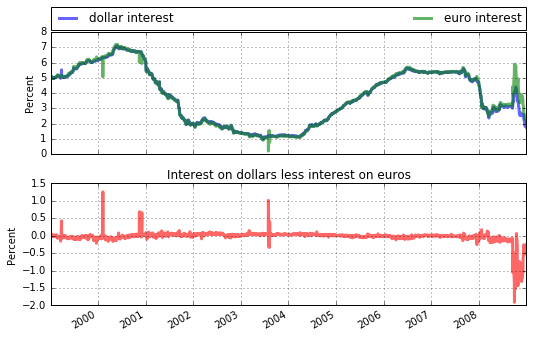

In [7]:
# Construct dollar-denominated return on euros
iEuro = 200*(1+euroFrame['euro interest']/200)*euroFrame['euro forward']/euroFrame['euro spot'] - 200

# Plot
fig = plt.figure(figsize=(7.5, 4.5))
ax = fig.add_subplot(2,1,1)
ax.plot_date(euroFrame.index,euroFrame['dollar interest'],'-',lw=3,alpha = 0.6,label='dollar interest')
ax.plot_date(euroFrame.index,iEuro,'-',lw=3,alpha = 0.6,label='euro interest')
ax.set_ylabel('Percent')
ax.grid()

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4, mode="expand", borderaxespad=0.)

ax = fig.add_subplot(2,1,2)
ax.plot_date(euroFrame.index,euroFrame['dollar interest']-iEuro,'-r',lw=3,alpha = 0.6)
ax.set_title('Interest on dollars less interest on euros')
ax.set_ylabel('Percent')
ax.grid()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('fig_dollarEuroCip.png',bbox_inches='tight',dpi=120)

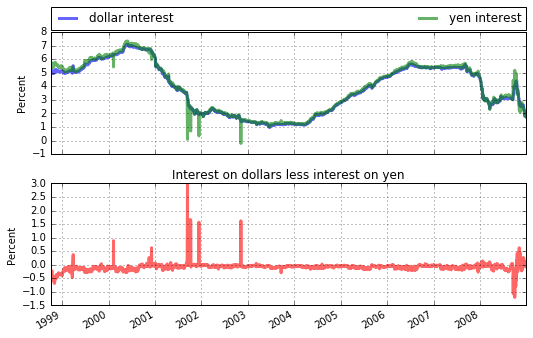

In [8]:
# Construct dollar-denominated return on euros
iyen = 200*(1+yenFrame['yen interest']/200)*yenFrame['yen forward']/yenFrame['yen spot'] - 200

# Plot
fig = plt.figure(figsize=(7.5, 4.5))
ax = fig.add_subplot(2,1,1)
ax.plot_date(yenFrame.index,yenFrame['dollar interest'],'-',lw=3,alpha = 0.6,label='dollar interest')
ax.plot_date(yenFrame.index,iyen,'-',lw=3,alpha = 0.6,label='yen interest')
ax.set_ylabel('Percent')
ax.grid()

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4, mode="expand", borderaxespad=0.)

ax = fig.add_subplot(2,1,2)
ax.plot_date(yenFrame.index,yenFrame['dollar interest']-iyen,'-r',lw=3,alpha = 0.6)
ax.set_title('Interest on dollars less interest on yen')
ax.set_ylabel('Percent')
ax.grid()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('fig_dollarYenCip.png',bbox_inches='tight',dpi=120)

# Monthly CIP data from Quandl

In [9]:
# Download pound data from Quandl and organize
poundForward = Quandl.get('BOE/XUMADS6', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
poundLibor = Quandl.get('BOE/IUMAVSMA', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
poundSpot = Quandl.get('BOE/XUMAUSS', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
dollarLibor = Quandl.get('BCB/3841', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")

poundForward.columns = ['pound forward']
poundSpot.columns = ['pound spot']
poundLibor.columns = ['pound interest']
dollarLibor.columns = ['dollar interest']

poundFrame = pd.concat([poundForward,poundSpot,poundLibor,dollarLibor],axis=1).dropna()

In [10]:
# Download franc data from Quandl and organize
francForward = Quandl.get('SNB/G3_M1_M', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
dollarLibor = Quandl.get('BCB/3841', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
francSpot = Quandl.get('BOE/XUMASFD', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
francLibor = Quandl.get('BCB/3843', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")

francForward = pd.DataFrame({'franc forward':1/francForward['6-month forward rate'].values},index = francForward['6-month forward rate'].index)
francForward
francSpot = 1/francSpot

francForward.columns = ['franc forward']
francSpot.columns = ['franc spot']
francLibor.columns = ['franc interest']
dollarLibor.columns = ['dollar interest']

francFrame = pd.concat([francForward,francSpot,francLibor,dollarLibor],axis=1).dropna()

In [11]:
# Pull Quandl data together and export to .csv
fullFrame = pd.concat([poundForward,poundLibor,poundSpot,francForward,francSpot,francLibor,dollarLibor],axis=1).dropna()
fullFrame[['pound spot', 'pound forward', 'pound interest', 'franc spot', 'franc forward','franc interest', 'dollar interest']].to_csv('cipPoundFrancMonthly.csv')

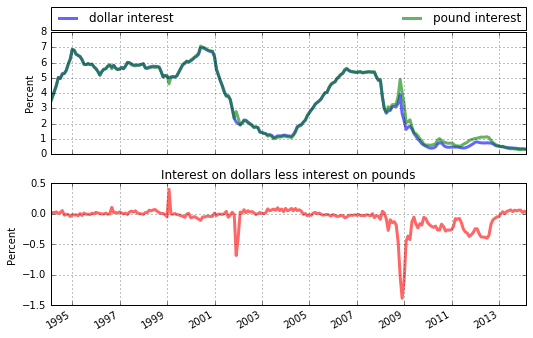

In [12]:
# Construct dollar-denominated return on pounds
ipound = 200*(1+poundFrame['pound interest']/200)*poundFrame['pound forward']/poundFrame['pound spot'] - 200

# Plot
fig = plt.figure(figsize=(7.5, 4.5))
ax = fig.add_subplot(2,1,1)
ax.plot_date(poundFrame.index,poundFrame['dollar interest'],'-',lw=3,alpha = 0.6,label='dollar interest')
ax.plot_date(poundFrame.index,ipound,'-',lw=3,alpha = 0.6,label='pound interest')
ax.set_ylabel('Percent')
ax.grid()

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4, mode="expand", borderaxespad=0.)

ax = fig.add_subplot(2,1,2)
ax.plot_date(poundFrame.index,poundFrame['dollar interest']-ipound,'-r',lw=3,alpha = 0.6)
ax.set_title('Interest on dollars less interest on pounds')
ax.set_ylabel('Percent')
ax.grid()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('fig_dollarPoundCip.png',bbox_inches='tight',dpi=120)

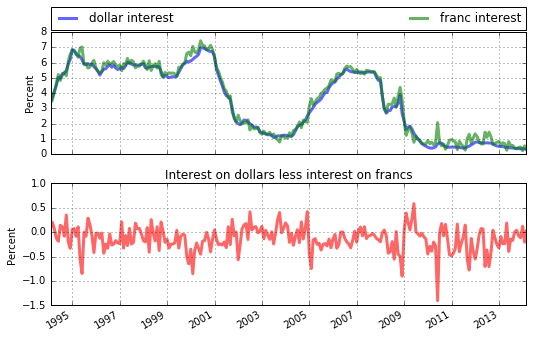

In [13]:
# Construct dollar-denominated return on francs
ifranc = 200*(1+francFrame['franc interest']/200)*francFrame['franc forward']/francFrame['franc spot'] - 200

# Plot
fig = plt.figure(figsize=(7.5, 4.5))
ax = fig.add_subplot(2,1,1)
ax.plot_date(francFrame.index,francFrame['dollar interest'],'-',lw=3,alpha = 0.6,label='dollar interest')
ax.plot_date(francFrame.index,ifranc,'-',lw=3,alpha = 0.6,label='franc interest')
ax.set_ylabel('Percent')
ax.grid()

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4, mode="expand", borderaxespad=0.)

ax = fig.add_subplot(2,1,2)
ax.plot_date(francFrame.index,francFrame['dollar interest']-ifranc,'-r',lw=3,alpha = 0.6)
ax.set_title('Interest on dollars less interest on francs')
ax.set_ylabel('Percent')
ax.grid()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('fig_dollarFrancCip.png',bbox_inches='tight',dpi=120)